# Базовый пример выполнения задания хакатона

**Задача — автоматически находить на спутниковых снимках следующие объекты:**

| Класс | Описание |
|-------|----------|
| Отвалы | Насыпи из пустой породы |
| Карьерные ямы | Котлованы добычи |
| Хвостохранилища | Отходы обогащения |


## Подключение необходимых модулей

In [1]:
!pip install numpy  # Работа с массивами
!pip install rasterio  # Работа с геоданными
!pip install matplotlib  # Работа с инфографиками
!pip install torch  # Фреймворк машинного обучения
!pip install segmentation-models-pytorch  # Базовые модели для семантической сегментации

!pip install tqdm  # Прогресс бар


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run:

In [2]:
import os
import functools
import glob
import json
from tqdm import tqdm

import numpy as np
import rasterio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold

C:\Users\psgpe\PycharmProjects\JupyterProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Создание класса датасета
Функции датасета:
- Подгружает данные во время обучения
- Экономит оперативную память

In [71]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, classes=1, channels=None, return_paths=False):
        assert len(imgs) == len(masks), "imgs != masks"
        self.channels = channels
        self.classes = classes
        self.imgs = imgs
        self.masks = masks
        self.return_paths = return_paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, pos):
        pth_tif = self.imgs[pos]
        pth_mask = self.masks[pos]
        with rasterio.open(pth_tif) as f:
            img = f.read()

        if self.channels: img = img[np.array(self.channels)]
        with rasterio.open(pth_mask) as f:
            mask = f.read()

        # Место для генерации признаков

        mask = torch.from_numpy(mask[0].astype(np.int64))   # Преобразование масок и снимков в формат данных для обучение
        mask = F.one_hot(mask, num_classes=self.classes)
        mask = mask.detach().numpy()
        img = img.transpose(1, 2, 0)
        img = torch.from_numpy(img.astype(np.float32)).moveaxis(2, 0)
        mask = torch.from_numpy(mask.astype(np.int64)).moveaxis(2, 0)
        assert mask.shape[0] == (self.classes)
        return (img, mask, pth_tif, pth_mask) if self.return_paths else (img, mask)

## Подготовка датасетов для обучения

**Используемые каналы спутниковых снимков:**  
- B02: Синий (10 м),
- B03: Зеленый (10 м),
- B04: Красный (10 м),
- B05: Красный край (20 м),
- B06: Красный край (20 м),
- B07: Красный край (20 м).

### Создание переменных

In [72]:
import glob
import os
import hashlib

# === Настройки ===
DIR_DATASET = "C:\\Users\\psgpe\\Downloads"
NUM_CLASSES = 3

def md5sum(path):
    """Вычисляет MD5-хэш содержимого файла"""
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

# === Пути ===
LST_TRAIN_IMG  = glob.glob(os.path.join(DIR_DATASET, "train/train/train/image/*.tif"))
LST_TRAIN_MASK = glob.glob(os.path.join(DIR_DATASET, "train/train/train/mask/*.tif"))

LST_VAL_IMG  = glob.glob(os.path.join(DIR_DATASET, "train/train/val/image/*.tif"))
LST_VAL_MASK = glob.glob(os.path.join(DIR_DATASET, "train/train/val/mask/*.tif"))

LST_TEST_IMG = glob.glob(os.path.join(DIR_DATASET, "test/test/image/*.tif"))
LST_TEST_MASK = [
    os.path.join(DIR_DATASET, "train/train/val/mask", os.path.basename(p))
    for p in LST_TEST_IMG
]

# === Объединяем train+val ===
LST_IMG  = LST_TRAIN_IMG  + LST_VAL_IMG
LST_MASK = LST_TRAIN_MASK + LST_VAL_MASK

# === Проверка пересечений по содержимому ===
print("⚡ Считаем хэши тестовых изображений...")
test_hashes = {md5sum(p): os.path.basename(p) for p in LST_TEST_IMG}

print("⚡ Ищем пересечения...")
intersections = [p for p in LST_IMG if md5sum(p) in test_hashes]

if intersections:
    print(f"Найдены {len(intersections)} пересечений (по содержимому):")
    for p in intersections:
        print("  ", os.path.basename(p))
else:
    print("Пересечений train/val с test не найдено ✅")

# === Удаляем пересечения ===
removed_basenames = [os.path.basename(p) for p in intersections]

LST_IMG  = [p for p in LST_IMG  if os.path.basename(p) not in removed_basenames]
LST_MASK = [p for p in LST_MASK if os.path.basename(p) not in removed_basenames]

# === Итог ===
print(f"\nИтоговые размеры:")
print(f"Train+Val images: {len(LST_IMG)}")
print(f"Train+Val masks:  {len(LST_MASK)}")
print(f"Test images:      {len(LST_TEST_IMG)}")
print(f"Test masks:       {len(LST_TEST_MASK)}")


⚡ Считаем хэши тестовых изображений...
⚡ Ищем пересечения...
Найдены 10 пересечений (по содержимому):
   010.tif
   013.tif
   014.tif
   015.tif
   016.tif
   023.tif
   024.tif
   025.tif
   026.tif
   027.tif

Итоговые размеры:
Train+Val images: 736
Train+Val masks:  736
Test images:      10
Test masks:       10


In [73]:

# Каналы изображений, на которых будет обучаться модель
LST_CHANNELS = [
    0,  # B02 (BLUE)
    1,  # B03 (GREEN)
    2,  # B04 (RED)
    3,  # B05 (VRE)
    4,  # B06 (VRE)
    5,  # B07 (VRE)
]
NUM_CHANNELS = len(LST_CHANNELS)  # Кол-во каналов
BATCH_SIZE = 32  # Размер батча
K_FOLDS = 10


In [30]:
for i in range(len(LST_TEST_IMG)):
    LST_TEST_IMG[i] = DIR_DATASET + "/train/train/val/image/" + LST_TEST_IMG[i][-7:]
LST_TEST_MASK = []
for i in range(len(LST_TEST_IMG)):
    LST_TEST_MASK.append(DIR_DATASET + "/train/train/val/mask/" + LST_TEST_IMG[i][-7:])

In [31]:
LST_IMG = LST_TRAIN_IMG + LST_VAL_IMG
LST_MASK = LST_TRAIN_MASK + LST_VAL_MASK

In [32]:
for i in range(len(LST_TEST_IMG)):
    LST_IMG.remove(LST_TEST_IMG[i])
    LST_MASK.remove(LST_TEST_MASK[i])

ValueError: list.remove(x): x not in list

### Создание датасетов

In [74]:
dataset = Dataset(
    LST_IMG,
    LST_MASK,
    NUM_CLASSES,
    LST_CHANNELS
)

dataset_test = Dataset(
    LST_TEST_IMG,
    LST_TEST_MASK,
    NUM_CLASSES,
    LST_CHANNELS
)

### Создание загрузчиков данных
Функции загрузчиков данных:
- перемешивают данные в датасетах
- разделяют датасеты на батчи

In [75]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

## Создание обучаемой модели

**Модель UNet**

In [76]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", DEVICE)

model = smp.Unet(
    encoder_name="efficientnet-b4",   # мощный энкодер
    encoder_weights="imagenet",
    in_channels=NUM_CHANNELS,       # Количество каналов изображения
    classes=NUM_CLASSES,            # Количество классов (включая фон)
)
#model.load_state_dict(torch.load('/kaggle/working/test1/model_epoch_10_acc_0.9032.pth', weights_only=True))
model.to(DEVICE)
print("OK")

Используемое устройство: cuda
OK


## Создание функции для обучения моделей

**Входные параметры**
- **model** - обучаемая модель
- **num_classes** - количество классов
- **optimizer** - оптимизатор
- **loss_fn** - лосс функция
- **acc_fn** - метрика
- **epochs** - количество эпох
- **data_tr** - обучающий датасет
- **data_val** - валидационный датасет
- **scheduler** - планировщик

**Возвращает историю обучения модели**

In [77]:
def Trainer(model, num_classes, optimizer, loss_fn, acc_fn, epochs, dataset, data_test, scheduler=None):
    # История обучения
    history = []
    best_test_acc = 0.0
    # Цикл эпох
    for epoch in range(epochs):

        # Инициализация переменных для обучения
        kf = KFold(n_splits=K_FOLDS, shuffle=True)
        for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
            data_tr = DataLoader(
                dataset=dataset,
                batch_size=BATCH_SIZE,
                sampler=torch.utils.data.SubsetRandomSampler(train_idx),
            )
            data_val = DataLoader(
                dataset=dataset,
                batch_size=BATCH_SIZE,
                sampler=torch.utils.data.SubsetRandomSampler(test_idx),
            )
            lr = None
            if scheduler:
                lr = scheduler.get_last_lr()[0]
            else:
                for param_group in optimizer.param_groups:
                    lr = param_group['lr']
            train_loss = 0
            train_acc = 0
            train_accs = [0]*num_classes
            model.train()
    
            # Подцикл обучения
            stream = tqdm(data_tr)
            for ind, (X_batch, Y_batch) in enumerate(stream):
                X_batch = X_batch.to(DEVICE)
                Y_batch = Y_batch.to(DEVICE)
                Y_pred = model.forward(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                loss.backward()
    
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
    
                train_loss += loss.item() / len(data_tr)
                avg, accs = acc_fn(Y_batch, Y_pred)
                train_acc += (avg).mean().item()/len(data_tr)
                train_accs = [train_accs[i] + acc/len(data_tr) for i, acc in enumerate(accs.tolist())]
                straccs = ', '.join([f"{acc:.04f}" for acc in train_accs])
                stream.set_description(
                    f"Epoch {epoch + 1:{len(str(epochs + 1))}d}. Train. " +
                    f"Loss: {train_loss:.04f} | Accs: {straccs} | Avg: {train_acc:.04f} | LR: {lr:.10f}")

            # Инициализация переменных для кросс-валидации
            val_loss = 0
            val_acc = 0
            val_accs = [0]*num_classes
    
            # Подцикл кросс-валидации
            model.eval()
            stream = tqdm(data_val)
            with torch.set_grad_enabled(False):
                for X_val, Y_val in stream:
                    Y_val = Y_val.to(DEVICE)
                    Y_hat = model(X_val.to(DEVICE)) # detach and put into cpu
                    val_loss += loss_fn(Y_val, Y_hat).mean().item()/len(data_val)
                    avg, accs = acc_fn(Y_val, Y_hat)
                    val_acc += (avg).mean().item()/len(data_val)
                    val_accs = [val_accs[i] + acc/len(data_val) for i, acc in enumerate(accs.tolist())]
                    straccs = ', '.join([f"{acc:.04f}" for acc in val_accs])
                    stream.set_description(
                        f"Epoch {epoch + 1:{len(str(epochs + 1))}d}. " + f"_Fold{fold + 1}" +
                        f"Valid. Loss: {val_loss:.04f} | Accs: {straccs} | Avg: {val_acc:.04f} | LR: {lr:.10f}"
                    )
            # Инициализация переменных для тестирования
            test_loss = 0
            test_acc = 0
            test_accs = [0]*num_classes
    
            # Подцикл тестирования
            model.eval()
            stream = tqdm(data_test)
            with torch.set_grad_enabled(False):
                for X_test, Y_test in stream:
                    Y_test = Y_test.to(DEVICE)
                    Y_hat = model(X_test.to(DEVICE)) # detach and put into cpu
                    test_loss += loss_fn(Y_test, Y_hat).mean().item()/len(data_test)
                    avg, accs = acc_fn(Y_test, Y_hat)
                    test_acc += (avg).mean().item()/len(data_test)
                    test_accs = [test_accs[i] + acc/len(data_test) for i, acc in enumerate(accs.tolist())]
                    straccs = ', '.join([f"{acc:.04f}" for acc in test_accs])
                    stream.set_description(
                        f"Epoch {epoch + 1:{len(str(epochs + 1))}d}. " + f"_Fold{fold + 1}" +
                        f"Test. Loss: {test_loss:.04f} | Accs: {straccs} | Avg: {test_acc:.04f} | LR: {lr:.10f}"
                    )
    
            history.append({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "train_accs": train_accs,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_accs": val_accs,
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_accs": test_accs,
                "lr": lr,
            })
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                # Сохраняем новую лучшую модель
                model_name = f"model_epoch_{epoch+1}_acc_{best_test_acc:.4f}.pth"
                best_model_path = os.path.join(DIR_SAVE, model_name)
                torch.save(model.state_dict(), best_model_path)
            
            if scheduler: scheduler.step()

    return history

## Функция точности

In [78]:
def mean_iou(true, pred, num_classes):
    true = torch.argmax(true, dim = 1)
    pred = torch.argmax(torch.softmax(pred, dim = 1), dim = 1)

    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()

    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    EPS = 1e-8
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = torch.nanmean(jaccard)

    return avg_jacc, jaccard

## Функция потерь

In [105]:
def cs_loss(y_real, y_pred):
    loss = nn.CrossEntropyLoss()
    return loss(y_pred, torch.argmax(y_real, dim=1))

## Обучение модели

### Определение гиперпараметров обучения

In [80]:
!mkdir test1

�������� ��� 䠩� test1 㦥 �������.


In [81]:
LR = 0.0001                                                                #параметр скорости обучения
NUM_EPOCHS = 25                                                           #кол-во эпох
FN_LOSS = cs_loss                                                          #ф-ция ошибки
FN_ACC = functools.partial(mean_iou, num_classes=NUM_CLASSES)

# Здесь указать папку, куда сохранять веса модели и показатели обучения
DIR_SAVE = r"C:\\Users\\psgpe\\Downloads\\hackj"

opt = torch.optim.Adam(model.parameters(), lr=LR)                           #оптимизатор
sch = None

### Обучение модели и сохранение результатов

In [82]:
print(K_FOLDS)

10


In [83]:
history = Trainer(model=model, optimizer=opt,
                loss_fn=FN_LOSS, acc_fn=FN_ACC, dataset=dataset, data_test=dataloader_test, num_classes=NUM_CLASSES,
                epochs=NUM_EPOCHS, scheduler=sch)


# Сохранение весов модели
torch.save(model.state_dict(), os.path.join(DIR_SAVE, "model_weights.pth"))

# Сохранение истории обучения
with open(os.path.join(DIR_SAVE, "history.json"), "w") as f:
    json.dump(history, f, indent=4)

Epoch  1. Train. Loss: 0.8187 | Accs: 0.6022, 0.4021, 0.0764 | Avg: 0.3602 | LR: 0.0001000000: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s]
Epoch  1. _Fold1Valid. Loss: 0.7735 | Accs: 0.6764, 0.0185, 0.0000 | Avg: 0.2316 | LR: 0.0001000000: 100%|██████████| 3/3 [00:00<00:00,  4.08it/s]
Epoch  1. _Fold1Test. Loss: 0.8129 | Accs: 0.6827, 0.0075, 0.0000 | Avg: 0.2301 | LR: 0.0001000000: 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]
Epoch  1. Train. Loss: 0.4981 | Accs: 0.8546, 0.6898, 0.2184 | Avg: 0.5876 | LR: 0.0001000000: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]
Epoch  1. _Fold2Valid. Loss: 0.8469 | Accs: 0.6579, 0.0053, 0.0000 | Avg: 0.2210 | LR: 0.0001000000: 100%|██████████| 3/3 [00:00<00:00,  4.23it/s]
Epoch  1. _Fold2Test. Loss: 0.8466 | Accs: 0.6869, 0.0021, 0.0000 | Avg: 0.2296 | LR: 0.0001000000: 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]
Epoch  1. Train. Loss: 0.3667 | Accs: 0.9011, 0.7712, 0.2925 | Avg: 0.6550 | LR: 0.0001000000: 100%|██████████| 21/21 [00:08<00:

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b4",   # мощный энкодер
    encoder_weights="imagenet",
    in_channels=NUM_CHANNELS,       # Количество каналов изображения
    classes=NUM_CLASSES,            # Количество классов (включая фон)
)
#model.load_state_dict(torch.load('/kaggle/working/test1/model_epoch_10_acc_0.9032.pth', weights_only=True))
model.to(DEVICE)
print("OK")

## Построение графиков обучения

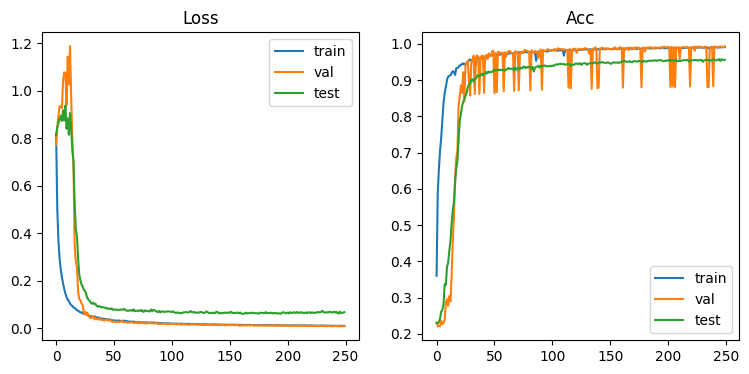

In [84]:
train_losses = [x["train_loss"] for x in history]
val_losses = [x["val_loss"] for x in history]
test_losses = [x["test_loss"] for x in history]
train_metrics = [x["train_acc"] for x in history]
val_metrics = [x["val_acc"] for x in history]
test_metrics = [x["test_acc"] for x in history]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].plot(range(NUM_EPOCHS * K_FOLDS), train_losses, label="train")
ax[0].plot(range(NUM_EPOCHS * K_FOLDS), val_losses, label="val")
ax[0].plot(range(NUM_EPOCHS * K_FOLDS), test_losses, label="test")
ax[0].legend(loc='best')
ax[0].set_title("Loss")
ax[1].plot(range(NUM_EPOCHS * K_FOLDS), train_metrics, label="train")
ax[1].plot(range(NUM_EPOCHS * K_FOLDS), val_metrics, label="val")
ax[1].plot(range(NUM_EPOCHS * K_FOLDS), test_metrics, label="test")
ax[1].legend(loc='best')
ax[1].set_title("Acc")
plt.show()

## Инференс

**Функция принимает следующие параметры:**
- **data_val** - валидационный датасет
- **model** - обученная модель
- **N** - количество предсказаний модели

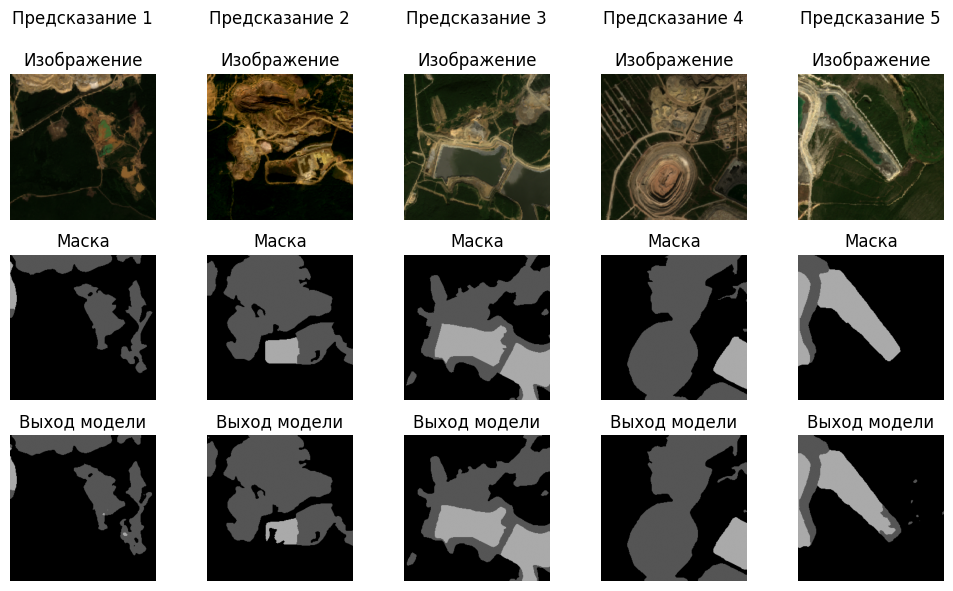

In [85]:
def inference(data_val, model, N):                                               #функция визуалиции для валид
    data_val = DataLoader(data_val, batch_size=1, shuffle=True, pin_memory=True)
    model.eval()
    fig, ax = plt.subplots(3, N, figsize=(N*2, 3*2))
    for i, (x, y) in list(enumerate(data_val))[:N]:
        img = x.squeeze().detach().numpy()
        msk = y.squeeze().detach().numpy()
        x = x.to(DEVICE)
        with torch.set_grad_enabled(False):
            output = model(x)
        y_ = torch.argmax(torch.softmax(output, dim = 1), dim = 1)
        y_ = y_.cpu().squeeze().detach().numpy()
        rgb = img[[2, 1, 0]].transpose(1, 2, 0)
        rgb = np.interp(rgb, [rgb.min(), rgb.max()], [0, 1])
        fmsk = np.zeros_like(msk[0])
        for j in range(1, msk.shape[0]):
            fmsk[msk[j] != 0] = j
        ax[0][i].imshow(rgb)
        ax[0][i].axis("off")
        ax[0][i].set_title(f"Предсказание {i + 1}\n\nИзображение")
        ax[1][i].imshow(fmsk, cmap='gray', vmin=0, vmax=3)
        ax[1][i].axis("off")
        ax[1][i].set_title("Маска")
        ax[2][i].imshow(y_, cmap='gray', vmin=0, vmax=3)
        ax[2][i].axis("off")
        ax[2][i].set_title("Выход модели")
    plt.tight_layout()
    plt.show()

inference(dataset_test, model, 5)

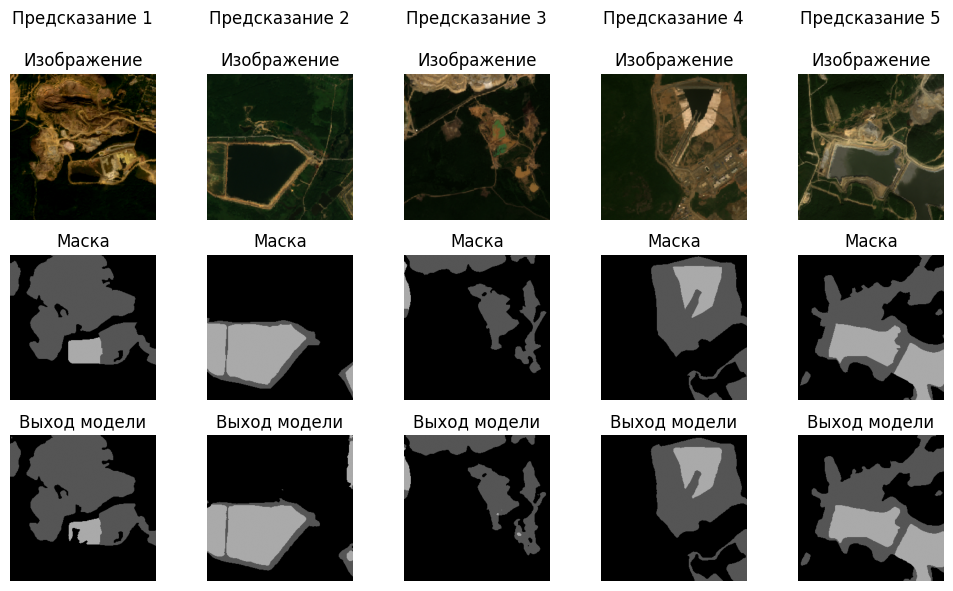

In [86]:
def inference(data_val, model, N):                                               #функция визуалиции для валид
    data_val = DataLoader(data_val, batch_size=1, shuffle=True, pin_memory=True)
    model.eval()
    fig, ax = plt.subplots(3, N, figsize=(N*2, 3*2))
    for i, (x, y) in list(enumerate(data_val))[:N]:

        img = x.squeeze().detach().numpy()
        msk = y.squeeze().detach().numpy()
        x = x.to(DEVICE)
        with torch.set_grad_enabled(False):
            output = model(x)
        y_ = torch.argmax(torch.softmax(output, dim = 1), dim = 1)
        y_ = y_.cpu().squeeze().detach().numpy()
        rgb = img[[2, 1, 0]].transpose(1, 2, 0)
        rgb = np.interp(rgb, [rgb.min(), rgb.max()], [0, 1])
        fmsk = np.zeros_like(msk[0])
        for j in range(1, msk.shape[0]):
            fmsk[msk[j] != 0] = j
        ax[0][i].imshow(rgb)
        ax[0][i].axis("off")
        ax[0][i].set_title(f"Предсказание {i + 1}\n\nИзображение")
        ax[1][i].imshow(fmsk, cmap='gray', vmin=0, vmax=3)
        ax[1][i].axis("off")
        ax[1][i].set_title("Маска")
        ax[2][i].imshow(y_, cmap='gray', vmin=0, vmax=3)
        ax[2][i].axis("off")
        ax[2][i].set_title("Выход модели")
    plt.tight_layout()
    plt.show()

inference(dataset_test, model, 5)

In [103]:
LST_TEST_IMG = glob.glob(DIR_DATASET + "/test/test/image/*.tif")  # Список валидационных изображений
LST_TEST_MASK = glob.glob(DIR_DATASET + "/test/test/mask/*.tif")  # Список валидационных масок

In [104]:
LST_FINAL_TEST_IMG = glob.glob(DIR_DATASET + "/final_test/final_test/image/*.tif")  # Список валидационных изображений
LST_FINAL_TEST_MASK = glob.glob(DIR_DATASET + "/final_test/final_test/mask/*.tif")  # Список валидационных масок

In [111]:
import os
import numpy as np
import torch
import rasterio
from rasterio.transform import from_origin

# === базовые пути ===
DIR_OUT = r"C:\Users\psgpe\Downloads\hackj"
OUT_OPENSET = os.path.join(DIR_OUT, "segmentation_openset")
OUT_CLOSEDSET = os.path.join(DIR_OUT, "segmentation_closedset")
os.makedirs(OUT_OPENSET, exist_ok=True)
os.makedirs(OUT_CLOSEDSET, exist_ok=True)

# === фиксим DatasetT: возвращаем (img, pth) при return_paths=True ===
class DatasetT(torch.utils.data.Dataset):
    def __init__(self, imgs, classes=1, channels=None, return_paths=False):
        self.channels = channels
        self.classes = classes
        self.imgs = imgs
        self.return_paths = return_paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, pos):
        pth_tif = self.imgs[pos]
        with rasterio.open(pth_tif) as f:
            img = f.read()  # [C,H,W]
        if self.channels:
            img = img[np.array(self.channels)]
        # в torch: [C,H,W], float32
        img = torch.from_numpy(img.astype(np.float32))
        return (img, pth_tif) if self.return_paths else img

def validate_mask(mask_data):
    assert mask_data.shape == (256, 256), f"Неверный размер: {mask_data.shape}"
    assert mask_data.dtype == np.uint8, f"Неверный тип данных: {mask_data.dtype}"
    unique_values = np.unique(mask_data)
    allowed_values = {0, 1, 2, 3}
    assert set(unique_values).issubset(allowed_values), f"Недопустимые значения: {set(unique_values) - allowed_values}"

# единые метаданные для GeoTIFF-вывода (без геопривязки)
GT_META = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'width': 256,
    'height': 256,
    'count': 1,
    'crs': None,
    'transform': from_origin(0, 0, 1, 1),
    'nodata': 0,
}

@torch.no_grad()
def run_inference_and_save(img_paths, out_dir, channels, device, model):
    ds = DatasetT(img_paths, classes=NUM_CLASSES, channels=channels, return_paths=True)
    model.eval()
    os.makedirs(out_dir, exist_ok=True)

    for x, pth_img in ds:
        # x: [C,H,W] -> [1,C,H,W]
        x = x.unsqueeze(0).to(device)
        logits = model(x)                   # [1, K, H, W]
        y = torch.argmax(torch.softmax(logits, dim=1), dim=1)  # [1, H, W]
        y = y.squeeze(0).cpu().numpy().astype('uint8')

        validate_mask(y)

        out_name = os.path.basename(pth_img)      # сохраняем тем же именем
        out_path = os.path.join(out_dir, out_name)
        with rasterio.open(out_path, "w", **GT_META) as f:
            f.write_band(1, y)

    print(f"Saved {len(img_paths)} masks into: {out_dir}")

# === запускаем: open set и closed set ===
run_inference_and_save(LST_TEST_IMG, OUT_OPENSET, LST_CHANNELS, DEVICE, model)
run_inference_and_save(LST_FINAL_TEST_IMG, OUT_CLOSEDSET, LST_CHANNELS, DEVICE, model)

# (опционально) собрать ZIP-ы рядом с DIR_OUT
import shutil
shutil.make_archive(os.path.join(DIR_OUT, "test_answer"),  "zip", OUT_OPENSET)
shutil.make_archive(os.path.join(DIR_OUT, "final_test_answer"), "zip", OUT_CLOSEDSET)
print("ZIPs:", os.path.join(DIR_OUT, "test_answer.zip"), "и", os.path.join(DIR_OUT, "final_test_answer.zip"))


Saved 10 masks into: C:\Users\psgpe\Downloads\hackj\segmentation_openset
Saved 133 masks into: C:\Users\psgpe\Downloads\hackj\segmentation_closedset
ZIPs: C:\Users\psgpe\Downloads\hackj\test_answer.zip и C:\Users\psgpe\Downloads\hackj\final_test_answer.zip


In [40]:
!mkdir /kaggle/working/segmentation_openset

In [41]:
!mkdir /kaggle/working/segmentation_closedset

In [106]:
os.makedirs(r"C:\Users\psgpe\Downloads\hackj\segmentation_openset", exist_ok=True)
os.makedirs(r"C:\Users\psgpe\Downloads\hackj\segmentation_closedset", exist_ok=True)


In [107]:
class DatasetT(torch.utils.data.Dataset):
    def __init__(self, imgs, classes=1, channels=None, return_paths=False):
        self.channels = channels
        self.classes = classes
        self.imgs = imgs
        self.return_paths = return_paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, pos):
        pth_tif = self.imgs[pos]
        with rasterio.open(pth_tif) as f:
            img = f.read()
        if self.channels: img = img[np.array(self.channels)]
        img = img.transpose(1, 2, 0)
        img = torch.from_numpy(img.astype(np.float32)).moveaxis(2, 0)
        return (img, pth_tif) if self.return_paths else (img, mask)

In [108]:
def validate_mask(mask_data):
    assert mask_data.shape == (256, 256), f"Неверный размер: {mask_data.shape}"
    assert mask_data.dtype == np.uint8, f"Неверный тип данных: {mask_data.dtype}"
    unique_values = np.unique(mask_data)
    allowed_values = {0, 1, 2, 3}
    assert set(unique_values).issubset(allowed_values), f"Недопустимые значения: {set(unique_values) - allowed_values}"
    print("Маска соответствует требованиям")

In [109]:
from rasterio.transform import from_origin

DIR_OUT = r"C:\\Users\\psgpe\\Downloads\\hackj"

dataset_test_out = DatasetT(
    LST_TEST_IMG,
    NUM_CLASSES,
    LST_CHANNELS,
    return_paths=True
)

model.eval()
for i, (x, pth_img) in list(enumerate(dataset_test_out)):
    img = x.squeeze().detach().numpy()
    x = x.unsqueeze(dim=0)
    x = x.to(DEVICE)
    with torch.set_grad_enabled(False):
        output = model(x)
    y_ = torch.argmax(torch.softmax(output, dim=1), dim=1)
    y_ = y_.cpu().squeeze().detach().numpy()
    y_ = y_.astype("uint8")
    #print(y_)
    meta = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'width': 256,
    'height': 256,
    'count': 1,
    'crs': None,
    'transform': from_origin(0, 0, 1, 1),
    'nodata': 0
    }
    validate_mask(y_)
    with rasterio.open(os.path.join(DIR_OUT, rf"{os.path.basename(pth_img)}"), "w", **meta) as f:
        f.write_band(1, y_)

Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям
Маска соответствует требованиям


In [93]:
!zip -r test_answer.zip segmentation_openset

"zip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [94]:
!zip -r final_test_answer.zip segmentation_closedset

"zip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [110]:
import shutil

shutil.make_archive(r"C:\Users\psgpe\Downloads\hackj\test_answer", "zip", r"C:\Users\psgpe\Downloads\hackj\final_test_answer")



FileNotFoundError: [WinError 2] Не удается найти указанный файл: 'C:\\Users\\psgpe\\Downloads\\hackj\\final_test_answer'